In [24]:
# -----------------------------
# QB Anticipation & Decision Efficiency Analysis
# Using NFL Big Data Bowl Tracking Data
# -----------------------------
# Cell 1 — Imports & config
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Where your CSVs live (set to "." if same folder as notebook)
DATA_PATH = "./"

# output path
OUT_PATH = "./processed/"
os.makedirs(OUT_PATH, exist_ok=True)

# frame duration in seconds (Big Data Bowl is 10 fps)
FRAME_SEC = 0.1

print("Ready. DATA_PATH:", DATA_PATH)


Ready. DATA_PATH: ./


In [2]:
# Cell 2 — Load plays, players, games
plays = pd.read_csv(os.path.join(DATA_PATH, "plays.csv"))
players = pd.read_csv(os.path.join(DATA_PATH, "players.csv"))
games = pd.read_csv(os.path.join(DATA_PATH, "games.csv"))

print("Plays columns:", plays.columns.tolist())
print("Players columns:", players.columns.tolist())
print("Games shape:", games.shape)


Plays columns: ['gameId', 'playId', 'playDescription', 'quarter', 'down', 'yardsToGo', 'possessionTeam', 'playType', 'yardlineSide', 'yardlineNumber', 'offenseFormation', 'personnelO', 'defendersInTheBox', 'numberOfPassRushers', 'personnelD', 'typeDropback', 'preSnapVisitorScore', 'preSnapHomeScore', 'gameClock', 'absoluteYardlineNumber', 'penaltyCodes', 'penaltyJerseyNumbers', 'passResult', 'offensePlayResult', 'playResult', 'epa', 'isDefensivePI']
Players columns: ['nflId', 'height', 'weight', 'birthDate', 'collegeName', 'position', 'displayName']
Games shape: (253, 6)


In [3]:
# Cell 3 — Load & concat all week tracking files (week1.csv ... week17.csv if present)
week_files = sorted(glob.glob(os.path.join(DATA_PATH, "week*.csv")))
print("Found week files:", week_files)

# load lazily (to reduce memory spikes), but concat for convenience
tracking_list = []
for f in week_files:
    print("Loading", f)
    dfw = pd.read_csv(f)
    tracking_list.append(dfw)

df_tracking = pd.concat(tracking_list, ignore_index=True)
print("Tracking rows:", len(df_tracking))
print("Tracking columns:", df_tracking.columns.tolist())


Found week files: ['./week1.csv', './week10.csv', './week11.csv', './week12.csv', './week13.csv', './week14.csv', './week15.csv', './week16.csv', './week17.csv', './week2.csv', './week3.csv', './week4.csv', './week5.csv', './week6.csv', './week7.csv', './week8.csv', './week9.csv']
Loading ./week1.csv
Loading ./week10.csv
Loading ./week11.csv
Loading ./week12.csv
Loading ./week13.csv
Loading ./week14.csv
Loading ./week15.csv
Loading ./week16.csv
Loading ./week17.csv
Loading ./week2.csv
Loading ./week3.csv
Loading ./week4.csv
Loading ./week5.csv
Loading ./week6.csv
Loading ./week7.csv
Loading ./week8.csv
Loading ./week9.csv
Tracking rows: 18309388
Tracking columns: ['time', 'x', 'y', 's', 'a', 'dis', 'o', 'dir', 'event', 'nflId', 'displayName', 'jerseyNumber', 'position', 'frameId', 'team', 'gameId', 'playId', 'playDirection', 'route']


In [4]:
# Cell 4 — Basic sanity clean & types
# Ensure consistent dtypes for join keys
for df in [plays, players, games, df_tracking]:
    for c in ["gameId", "playId"]:
        if c in df.columns:
            if not np.issubdtype(df[c].dtype, np.integer):
                # try convert
                try:
                    df[c] = df[c].astype(int)
                except Exception:
                    pass

# Quick check
print("Unique events sample:", df_tracking["event"].dropna().unique()[:20])
print("Positions sample:", df_tracking["position"].dropna().unique())


Unique events sample: ['ball_snap' 'pass_forward' 'pass_arrived' 'pass_outcome_caught'
 'out_of_bounds' 'pass_outcome_incomplete' 'first_contact' 'tackle'
 'man_in_motion' 'play_action' 'qb_sack' 'fumble'
 'fumble_offense_recovered' 'handoff' 'pass_tipped'
 'pass_outcome_interception' 'qb_strip_sack' 'pass_shovel' 'line_set'
 'shift']
Positions sample: ['QB' 'SS' 'WR' 'FS' 'RB' 'MLB' 'CB' 'TE' 'LB' 'FB' 'OLB' 'HB' 'ILB' 'DL'
 'DB' 'NT' 'S' 'DE' 'P' 'LS' 'K' 'DT']


In [5]:
# Cell 5 — Identify throw frames (pass_forward) and catch frames (pass_outcome_caught)
# Throw frames (ball release)
throws = df_tracking[df_tracking["event"] == "pass_forward"][["gameId", "playId", "frameId", "nflId", "x", "y"]].copy()
throws = throws.rename(columns={"nflId": "passerId", "frameId": "throwFrame", "x":"ball_x_at_throw","y":"ball_y_at_throw"})
print("Throws found:", len(throws))

# Catch events (successful catches)
catches = df_tracking[df_tracking["event"] == "pass_outcome_caught"][["gameId", "playId", "frameId", "nflId", "x", "y"]].copy()
catches = catches.rename(columns={"nflId":"catchNflId", "frameId":"catchFrame", "x":"catch_x","y":"catch_y"})
print("Catches found:", len(catches))

# Some plays may have pass_outcome_intercepted (interception). We can capture if desired.
intercepts = df_tracking[df_tracking["event"] == "pass_outcome_interception"][["gameId","playId","frameId","nflId","x","y"]].copy()
intercepts = intercepts.rename(columns={"nflId":"interceptNflId","frameId":"interceptFrame","x":"int_x","y":"int_y"})
print("Interceptions found:", len(intercepts))


Throws found: 260480
Catches found: 160114
Interceptions found: 6154


In [6]:
# Cell 6 — Build play-level info: attach throwFrame and catch/intercept if present
# Some plays might have multiple entries for throws (rare). We'll keep the earliest pass_forward per play.
throw_play = throws.groupby(["gameId","playId"])[["throwFrame","passerId","ball_x_at_throw","ball_y_at_throw"]].first().reset_index()
print("Unique throw_play rows:", len(throw_play))

# catches: if multiple, keep earliest catch
catch_play = catches.groupby(["gameId","playId"])[["catchFrame","catchNflId","catch_x","catch_y"]].first().reset_index()
print("Unique catch_play rows:", len(catch_play))

# intercepts if present (keep earliest)
intercept_play = intercepts.groupby(["gameId","playId"])[["interceptFrame","interceptNflId","int_x","int_y"]].first().reset_index()
print("Unique intercept_play rows:", len(intercept_play))

# Merge throw + catch + intercept into play-level table
play_events = throw_play.merge(catch_play, on=["gameId","playId"], how="left").merge(intercept_play, on=["gameId","playId"], how="left")
print("Play events shape:", play_events.shape)


Unique throw_play rows: 17747
Unique catch_play rows: 10913
Unique intercept_play rows: 418
Play events shape: (17747, 14)


In [7]:
# Cell 7 — Merge play_events into plays to capture EPA and context
play_info = plays.merge(play_events, on=["gameId","playId"], how="left")
print("play_info shape:", play_info.shape)
play_info.head()


play_info shape: (19239, 39)


,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,playType,yardlineSide,yardlineNumber,...,ball_x_at_throw,ball_y_at_throw,catchFrame,catchNflId,catch_x,catch_y,interceptFrame,interceptNflId,int_x,int_y
0,2018090600,75,(15:00) M.Ryan pass short right to J.Jones pus...,1,1,15,ATL,play_type_pass,ATL,20,...,96.43,26.78,52.0,310.0,96.10,27.82,NaN,NaN,NaN,NaN
1,2018090600,146,(13:10) M.Ryan pass incomplete short right to ...,1,1,10,ATL,play_type_pass,PHI,39,...,53.88,29.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018090600,168,(13:05) (Shotgun) M.Ryan pass incomplete short...,1,2,10,ATL,play_type_pass,PHI,39,...,55.11,28.71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018090600,190,(13:01) (Shotgun) M.Ryan pass deep left to J.J...,1,3,10,ATL,play_type_pass,PHI,39,...,58.11,26.52,62.0,310.0,56.59,25.89,NaN,NaN,NaN,NaN
4,2018090600,256,(10:59) (Shotgun) M.Ryan pass incomplete short...,1,3,1,ATL,play_type_pass,PHI,1,...,16.97,24.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
# Simplest version: only use caught passes for target
play_info["targetId"] = play_info["catchNflId"]


In [21]:
# Cell 9 — Merge the play_info back into tracking so each row knows passerId, targetId, throwFrame, etc.
df = df_tracking.merge(
    play_info[["gameId","playId","passerId","targetId","throwFrame","catchFrame","epa","passResult"]],
    on=["gameId","playId"],
    how="left"
)

print("Merged df shape:", df.shape)


Merged df shape: (18309388, 25)


In [10]:
# Cell 10 — Extract QB rows and receiver rows (targetId)
df_qb = df[df["nflId"] == df["passerId"]].copy()
df_target = df[df["nflId"] == df["targetId"]].copy()

print("QB rows:", len(df_qb))
print("Target rows:", len(df_target))


QB rows: 1160310
Target rows: 736445


In [11]:
# COMPLETEED PASSES ONLY ( NO IMCOPLETE PASSES) 
# Cell 11 — Detect route break for the target using direction change heuristic
# We'll compute per-target direction change and keep the first frame where change > threshold
df_target = df_target.sort_values(["gameId","playId","nflId","frameId"]).copy()

# direction (dir) column exists in BDB (degrees). compute absolute diff
df_target["dir_prev"] = df_target.groupby(["gameId","playId","nflId"])["dir"].shift(1)
df_target["dirChange"] = (df_target["dir"] - df_target["dir_prev"]).abs()
# handle wrap-around (e.g., 350 -> 10 degrees should be 20)
df_target["dirChange"] = df_target["dirChange"].apply(lambda x: 360 - x if pd.notna(x) and x > 180 else x)

# threshold (degrees). 30 deg is a decent starting heuristic; you can tune this.
BREAK_DEGREE_THRESHOLD = 30
df_target["isBreak"] = df_target["dirChange"] > BREAK_DEGREE_THRESHOLD

# find first breakFrame per play
break_frames = df_target[df_target["isBreak"]].groupby(["gameId","playId","nflId"])["frameId"].min().reset_index().rename(columns={"frameId":"breakFrame"})
print("Detected break frames for targets (count):", len(break_frames))

# Merge breakFrame back into play_info (so one row per play has breakFrame)
play_info = play_info.merge(break_frames[["gameId","playId","nflId","breakFrame"]], left_on=["gameId","playId","targetId"], right_on=["gameId","playId","nflId"], how="left")
play_info = play_info.drop(columns=["nflId"])


Detected break frames for targets (count): 7959


In [12]:
# Cell 12 — Compute anticipation: throwFrame - breakFrame (frames -> seconds)
# Only keep plays where throwFrame exists and breakFrame exists
play_info["anticipation_frames"] = play_info["throwFrame"] - play_info["breakFrame"]
play_info["anticipation_seconds"] = play_info["anticipation_frames"] * FRAME_SEC

# Interpretations:
# negative anticipation_seconds => QB threw BEFORE the receiver break (anticipatory throw)
# positive => QB threw AFTER the break

# Show some summary stats
ant_summary = play_info["anticipation_seconds"].describe()
print("Anticipation summary (seconds):")
print(ant_summary)

# How many true anticipations (throw before break)?
num_anticipations = (play_info["anticipation_seconds"] < 0).sum()
total_with_both = play_info["anticipation_seconds"].dropna().shape[0]
print(f"Anticipatory throws (throw before break): {num_anticipations} / {total_with_both} ({num_anticipations/total_with_both:.2%})")


Anticipation summary (seconds):
count    7959.000000
mean        2.165737
std         1.636825
min       -10.200000
25%         1.700000
50%         2.400000
75%         3.100000
max        13.200000
Name: anticipation_seconds, dtype: float64
Anticipatory throws (throw before break): 828 / 7959 (10.40%)


In [13]:
# Cell 13 — Add some contextual columns (timeToThrow = throwFrame - snapFrame)
# We need to get snapFrame too. The event 'ball_snap' is used for the snap.
snap_rows = df_tracking[df_tracking["event"] == "ball_snap"][["gameId","playId","frameId"]].copy()
snap_rows = snap_rows.rename(columns={"frameId":"snapFrame"})
snap_play = snap_rows.groupby(["gameId","playId"])["snapFrame"].first().reset_index()

play_info = play_info.merge(snap_play, on=["gameId","playId"], how="left")
play_info["timeToThrow_sec"] = (play_info["throwFrame"] - play_info["snapFrame"]) * FRAME_SEC

# Quick checks
print("timeToThrow stats (sec):")
print(play_info["timeToThrow_sec"].describe())

# Save play-level output with anticipation + context
out_cols = [
    "gameId","playId","snapFrame","throwFrame","catchFrame","breakFrame",
    "timeToThrow_sec","anticipation_seconds","passResult","epa","targetId","passerId"
]
play_info[out_cols].to_csv(os.path.join(OUT_PATH, "play_level_anticipation.csv"), index=False)
print("Saved play-level anticipation csv to:", os.path.join(OUT_PATH, "play_level_anticipation.csv"))


timeToThrow stats (sec):
count    17747.000000
mean         2.761188
std          1.024020
min          0.500000
25%          2.100000
50%          2.600000
75%          3.200000
max         13.300000
Name: timeToThrow_sec, dtype: float64
Saved play-level anticipation csv to: ./processed/play_level_anticipation.csv


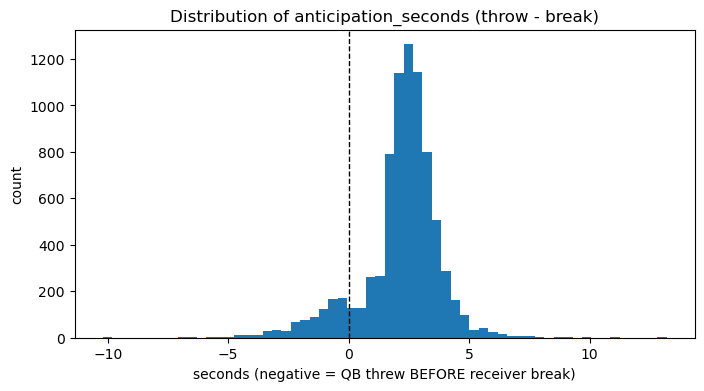

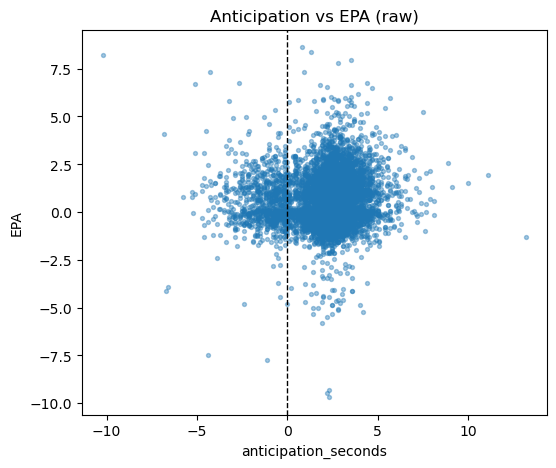

In [14]:
# Cell 14 — Basic visual checks (requires matplotlib)
import matplotlib.pyplot as plt

# Histogram of anticipation_seconds (drop NaN)
vals = play_info["anticipation_seconds"].dropna()
plt.figure(figsize=(8,4))
plt.hist(vals, bins=60)
plt.axvline(0, color='k', linestyle='dashed', linewidth=1)
plt.title("Distribution of anticipation_seconds (throw - break)")
plt.xlabel("seconds (negative = QB threw BEFORE receiver break)")
plt.ylabel("count")
plt.show()

# Scatter: anticipation vs EPA (drop NaN)
df_scatter = play_info[["anticipation_seconds","epa"]].dropna()
plt.figure(figsize=(6,5))
plt.scatter(df_scatter["anticipation_seconds"], df_scatter["epa"], alpha=0.4, s=8)
plt.xlabel("anticipation_seconds")
plt.ylabel("EPA")
plt.title("Anticipation vs EPA (raw)")
plt.axvline(0, color='k', linestyle='dashed', linewidth=1)
plt.show()


In [15]:
# Cell 15 — Save a sample of plays with key info for manual verification (limit 200)
play_info_sample = play_info.sort_values("snapFrame").head(200)
play_info_sample.to_csv(os.path.join(OUT_PATH, "play_info_sample_for_manual_verification.csv"), index=False)
print("Saved sample for verification:", os.path.join(OUT_PATH, "play_info_sample_for_manual_verification.csv"))
play_info_sample.head(20)


Saved sample for verification: ./processed/play_info_sample_for_manual_verification.csv


,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,playType,yardlineSide,yardlineNumber,...,interceptFrame,interceptNflId,int_x,int_y,targetId,breakFrame,anticipation_frames,anticipation_seconds,snapFrame,timeToThrow_sec
16971,2018122304,3883,(6:57) (Shotgun) T.Heinicke pass incomplete de...,4,1,10,CAR,play_type_pass,ATL,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2.7
16951,2018122304,2955,(4:45) (Shotgun) M.Ryan pass deep left to M.Sa...,3,1,10,ATL,play_type_pass,CAR,44,...,NaN,NaN,NaN,NaN,310.0,3.0,30.0,3.0,1,3.2
16952,2018122304,3034,"(4:11) (No Huddle, Shotgun) T.Heinicke pass sh...",3,2,2,CAR,play_type_pass,CAR,33,...,NaN,NaN,NaN,NaN,2532978.0,2.0,15.0,1.5,1,1.6
13159,2018120209,3019,"(11:57) (No Huddle, Shotgun) C.Newton pass sho...",4,2,11,CAR,play_type_pass,CAR,12,...,NaN,NaN,NaN,NaN,2495455.0,23.0,4.0,0.4,1,2.6
13329,2018120207,4184,(1:49) (Shotgun) C.Daniel pass short right to ...,4,1,10,CHI,play_type_pass,CHI,25,...,NaN,NaN,NaN,NaN,71197.0,23.0,-4.0,-0.4,1,1.8
15001,2018120911,1959,"(1:26) (No Huddle, Shotgun) M.Stafford pass sh...",2,1,10,DET,play_type_pass,DET,27,...,NaN,NaN,NaN,NaN,79860.0,3.0,20.0,2.0,1,2.2
16937,2018122304,2251,(:21) (Shotgun) T.Heinicke pass incomplete dee...,2,3,16,CAR,play_type_pass,CAR,45,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,5.3
16963,2018122304,3562,"(11:17) (No Huddle, Shotgun) T.Heinicke pass i...",4,1,10,CAR,play_type_pass,ATL,28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2.8
18341,2018123013,3345,"(11:34) (No Huddle, Shotgun) C.Keenum pass sho...",4,2,8,DEN,play_type_pass,LAC,29,...,NaN,NaN,NaN,NaN,2532861.0,NaN,NaN,NaN,1,1.8
4703,2018100400,2119,"(:49) (No Huddle, Shotgun) A.Luck pass short r...",2,1,10,IND,play_type_pass,IND,43,...,NaN,NaN,NaN,NaN,71251.0,NaN,NaN,NaN,1,1.9


In [16]:
# Cell 16 — Per-QB Aggregation Metrics

# Keep only plays with a valid passerId and anticipation_seconds
qb_df = play_info[
    play_info["passerId"].notna() & 
    play_info["anticipation_seconds"].notna()
].copy()

# Merge in player names (to get QB names)
players_short = players[["nflId", "displayName"]].rename(columns={"nflId": "passerId", "displayName": "QB"})
qb_df = qb_df.merge(players_short, on="passerId", how="left")

# --- Compute per-QB metrics ---
qb_summary = qb_df.groupby(["passerId", "QB"]).agg(
    plays=("playId", "count"),

    # Anticipation metrics
    mean_anticipation=("anticipation_seconds", "mean"),
    median_anticipation=("anticipation_seconds", "median"),
    pct_anticipatory=("anticipation_seconds", lambda x: (x < 0).mean()),   # threw before break

    # Time-to-throw
    mean_ttt=("timeToThrow_sec", "mean"),
    median_ttt=("timeToThrow_sec", "median"),

    # EPA
    mean_epa=("epa", "mean"),
    total_epa=("epa", "sum"),

    # Completion rate only when catchFrame exists
    completion_rate=("catchFrame", lambda x: x.notna().mean())
).reset_index()

# Sort by most anticipatory
qb_summary = qb_summary.sort_values("mean_anticipation")

# Save
qb_summary.to_csv(os.path.join(OUT_PATH, "qb_anticipation_summary.csv"), index=False)

print("Saved QB summary:", os.path.join(OUT_PATH, "qb_anticipation_summary.csv"))
qb_summary.head(20)


Saved QB summary: ./processed/qb_anticipation_summary.csv


,passerId,QB,plays,mean_anticipation,median_anticipation,pct_anticipatory,mean_ttt,median_ttt,mean_epa,total_epa,completion_rate
188,2539289.0,Kenjon Barner,1,-2.100000,-2.10,1.000000,2.700000,2.70,-0.587927,-0.587927,1.0
134,2506969.0,Sam Koch,1,-0.500000,-0.50,1.000000,2.400000,2.40,4.118470,4.118470,1.0
99,2495459.0,Torrey Smith,2,0.500000,0.50,0.500000,2.750000,2.75,0.019957,0.039914,1.0
170,2532986.0,Tahir Whitehead,2,0.500000,0.50,0.500000,3.550000,3.55,1.411568,2.823135,1.0
200,2540258.0,Travis Kelce,2,0.750000,0.75,0.500000,1.900000,1.90,0.492470,0.984940,1.0
163,2532948.0,Harrison Smith,14,0.850000,0.35,0.357143,2.985714,2.60,0.215291,3.014074,1.0
104,2495493.0,Justin Houston,4,0.950000,1.70,0.250000,1.975000,1.95,1.422561,5.690244,1.0
57,497240.0,Rob Gronkowski,14,1.128571,2.15,0.285714,2.628571,2.60,0.398657,5.581198,1.0
181,2535609.0,DeShawn Shead,3,1.133333,0.00,0.333333,3.333333,3.50,0.279093,0.837279,1.0
41,494307.0,Darian Stewart,98,1.139796,2.05,0.285714,2.539796,2.35,0.996460,97.653096,1.0


In [25]:
# Drop plays where anticipation or EPA is missing
reg_data = play_info[["anticipation_seconds", "epa"]].dropna()

X = reg_data["anticipation_seconds"]  # independent variable
y = reg_data["epa"]                   # dependent variable


In [26]:
X_sm = sm.add_constant(X)  # add intercept
model = sm.OLS(y, X_sm).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                    epa   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     48.18
Date:                Tue, 25 Nov 2025   Prob (F-statistic):           4.19e-12
Time:                        14:42:56   Log-Likelihood:                -13475.
No. Observations:                7989   AIC:                         2.695e+04
Df Residuals:                    7987   BIC:                         2.697e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.5198 

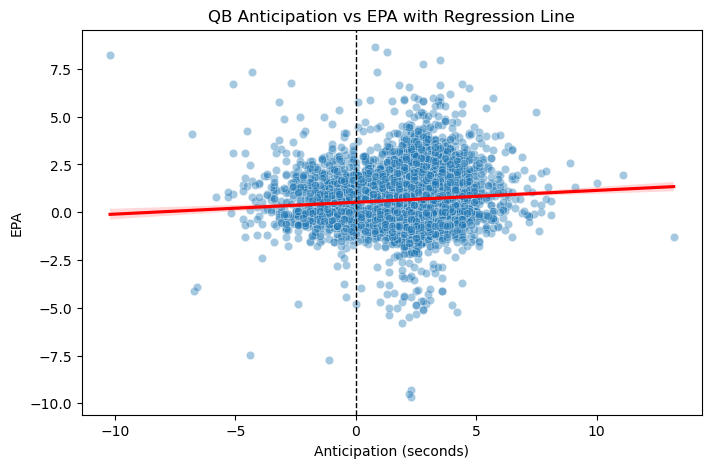

In [27]:
plt.figure(figsize=(8,5))
sns.scatterplot(x="anticipation_seconds", y="epa", data=reg_data, alpha=0.4)
sns.regplot(x="anticipation_seconds", y="epa", data=reg_data, scatter=False, color="red")
plt.axvline(0, color='k', linestyle='--', linewidth=1)
plt.xlabel("Anticipation (seconds)")
plt.ylabel("EPA")
plt.title("QB Anticipation vs EPA with Regression Line")
plt.show()


In [28]:
qbs = play_info["passerId"].unique()
for qb in qbs[:5]:  # example: first 5 QBs
    qb_data = play_info[(play_info["passerId"]==qb) & play_info["anticipation_seconds"].notna() & play_info["epa"].notna()]
    if len(qb_data) > 10:
        X = sm.add_constant(qb_data["anticipation_seconds"])
        y = qb_data["epa"]
        model = sm.OLS(y, X).fit()
        print(f"QB {qb} regression summary:")
        print(model.summary())


QB 310.0 regression summary:
                            OLS Regression Results                            
Dep. Variable:                    epa   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     6.213
Date:                Tue, 25 Nov 2025   Prob (F-statistic):             0.0131
Time:                        14:43:16   Log-Likelihood:                -654.66
No. Observations:                 396   AIC:                             1313.
Df Residuals:                     394   BIC:                             1321.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
con

/opt/anaconda3/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=16 observations were given.
  return hypotest_fun_in(*args, **kwds)


Top 10 Most Consistent QBs (lowest std deviation in anticipation):
      passerId  mean_anticipation  std_anticipation  n_throws
175  2532888.0           2.175862          0.784062        29
183  2532978.0           2.624000          0.807403        25
223  2543477.0           2.569565          0.882885        23
131  2506340.0           2.525000          0.931461        64
190  2533039.0           2.830000          0.950916        30
89   2495288.0           2.652500          0.986053        40
103  2495466.0           2.696078          0.997389        51
27     79860.0           2.406567          1.007763       335
72   2495143.0           2.411340          1.009215        97
187  2533031.0           2.259091          1.010732        22


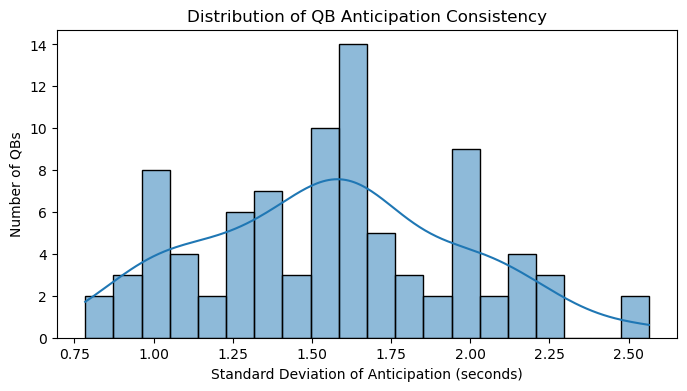

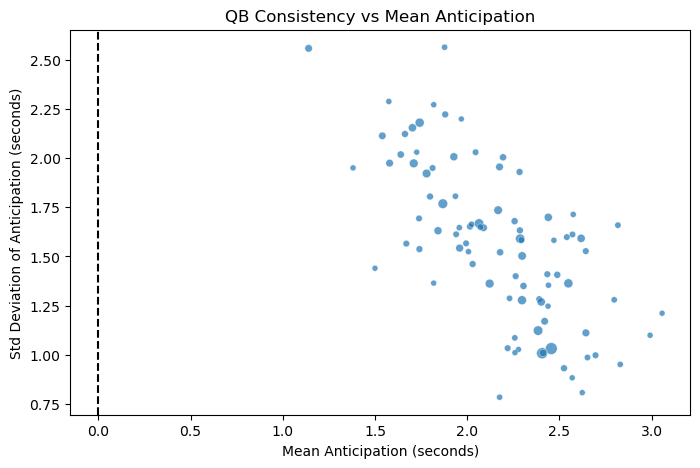

In [34]:
# DO THE TOP QUATERBACKS HAVE A MORE CONSISTENT ANTICIPATION TIME 

# --- QB Consistency Analysis: Standard Deviation of Anticipation ---

import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Aggregate per QB
qb_stats = play_info.groupby("passerId").agg(
    mean_anticipation=('anticipation_seconds', 'mean'),
    std_anticipation=('anticipation_seconds', 'std'),
    n_throws=('anticipation_seconds', 'count'),
    mean_epa=('epa', 'mean')
).reset_index()

# Filter out QBs with very few throws to avoid noisy statistics
qb_stats = qb_stats[qb_stats['n_throws'] >= 20]

# 2️⃣ Sort by standard deviation (most consistent first)
qb_stats_sorted = qb_stats.sort_values("std_anticipation")

# 3️⃣ Display top 10 most consistent QBs
print("Top 10 Most Consistent QBs (lowest std deviation in anticipation):")
print(qb_stats_sorted[['passerId','mean_anticipation','std_anticipation','n_throws']].head(10))

# 4️⃣ Visualize: Histogram of std deviation
plt.figure(figsize=(8,4))
sns.histplot(qb_stats['std_anticipation'], bins=20, kde=True)
plt.xlabel("Standard Deviation of Anticipation (seconds)")
plt.ylabel("Number of QBs")
plt.title("Distribution of QB Anticipation Consistency")
plt.show()

# 5️⃣ Visualize: Scatter of mean vs std deviation, size by number of throws
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="mean_anticipation",
    y="std_anticipation",
    size="n_throws",
    data=qb_stats,
    alpha=0.7,
    legend=False
)
plt.axvline(0, color='k', linestyle='--')
plt.xlabel("Mean Anticipation (seconds)")
plt.ylabel("Std Deviation of Anticipation (seconds)")
plt.title("QB Consistency vs Mean Anticipation")
plt.show()


In [40]:
# Top 10 based on the list from the NFL 
top10_names = [
    "Tom Brady", "Aaron Rodgers", "Josh Allen", "Justin Herbert", "Matthew Stafford",
    "Joe Burrow", "Patrick Mahomes", "Kyler Murray", "Derek Carr", "Russell Wilson"
]
# Filter players.csv for these names
top10_players = players[players['displayName'].isin(top10_names)][['nflId','displayName','position']]

# Verify they are all QBs
print(top10_players)

# Only include plays where passerId is one of the top 10 QBs
top10_plays = play_info[play_info['passerId'].isin(top10_players['nflId'])].copy()

top10_qb_stats = top10_plays.groupby('passerId').agg(
    mean_anticipation=('anticipation_seconds','mean'),
    std_anticipation=('anticipation_seconds','std'),
    n_throws=('anticipation_seconds','count'),
    mean_epa=('epa','mean')
).reset_index()

# Merge to get names
top10_qb_stats = top10_qb_stats.merge(top10_players[['nflId','displayName']], left_on='passerId', right_on='nflId', how='left')
top10_qb_stats = top10_qb_stats[['displayName','mean_anticipation','std_anticipation','n_throws','mean_epa']]

# Sort by std_anticipation to see most consistent
top10_qb_stats = top10_qb_stats.sort_values('std_anticipation')
top10_qb_stats


       nflId       displayName position
93   2560955        Josh Allen       QB
244  2504211         Tom Brady       QB
461  2506363     Aaron Rodgers       QB
508    79860  Matthew Stafford       QB
566  2543499        Derek Carr       QB
670  2558125   Patrick Mahomes       QB
798  2532975    Russell Wilson       QB


,displayName,mean_anticipation,std_anticipation,n_throws,mean_epa
1,Tom Brady,1.628571,0.851889,7,0.823715
0,Matthew Stafford,2.406567,1.007763,335,0.160883
3,Russell Wilson,1.650000,1.202082,2,1.507541
2,Aaron Rodgers,3.000000,NaN,1,2.777673
